In [1]:
import findspark as fs

import random
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Circle
import pandas as pd

print(sys.executable)
print(sys.path)
print(sys.version)

import photutils
from photutils import detect_threshold
from astropy.io import fits
from astropy.wcs import WCS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.modeling.functional_models import Gaussian2D

#from pyspark.sql.types import Row
from pyspark import SparkContext
from pyspark.sql import SparkSession

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from photutils import detect_sources
import time

import shutil
from math import pi, log, sqrt

import warnings
warnings.filterwarnings("ignore")

/home/s2494876/miniconda3/envs/sddm/bin/python
['/home/s2494876/miniconda3/envs/sddm/lib/python36.zip', '/home/s2494876/miniconda3/envs/sddm/lib/python3.6', '/home/s2494876/miniconda3/envs/sddm/lib/python3.6/lib-dynload', '', '/home/s2494876/.local/lib/python3.6/site-packages', '/home/s2494876/miniconda3/envs/sddm/lib/python3.6/site-packages', '/home/s2494876/.local/lib/python3.6/site-packages/IPython/extensions', '/home/s2494876/.ipython']
3.6.10 |Anaconda, Inc.| (default, Mar 25 2020, 23:51:54) 
[GCC 7.3.0]


In [8]:
try:
    sc = SparkContext(appName="SDDM")
    #, master='spark://fs.dslc.liacs.nl:7078')
except ValueError:
    warnings.warn("SparkContext already exists in this scope")
    print('warn')
    
print(sc._conf.get('spark.driver.memory'))

warn
None


In [9]:
# Define data paths
DR2_path = "/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2/"
mosaic_path = "/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/"
writeable = "/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_writable/"

# Calculate radius mosaic

In [10]:
def mosaic(file):
    hdul = fits.open(file)
    # data = hdul[0].data # The intensity data
    conv = hdul[0]._header["BMAJ"] # Should be 1/4 * BMAJ
    
    x = hdul[0]._header['NAXIS1']
    y = hdul[0]._header['NAXIS2']
    center = (x/2, y/2)

    # finite_area = np.sum(np.isfinite(data))
    # radius = np.sqrt(finite_area/pi) * conv
    radius = (max(x, y) / 2) * conv * (3/8)
    
    w = WCS(hdul[0].header)
    ra, dec = w.all_pix2world(x/2, y/2, 0, ra_dec_order=True)
    
    return np.array((radius, ra, dec))

In [11]:
fits_files = [mosaic_path + f for f in os.listdir(mosaic_path)]
random.shuffle(fits_files)
file_paths = sc.parallelize(fits_files, 32) # , len(fits_files)
file_paths.collect()

['/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P037+39_mosaic-blanked.fits',
 '/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P160+55_mosaic-blanked.fits',
 '/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P142+50_mosaic-blanked.fits',
 '/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P40Hetdex19_mosaic-blanked.fits',
 '/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P240+45_mosaic-blanked.fits',
 '/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P227+50_mosaic-blanked.fits',
 '/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P223+52_mosaic-blanked.fits',
 '/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P141+57_mosaic-blanked.fits',
 '/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P37Hetdex15_mosaic-blanked.fits',
 '/data/astronomy-big-data/bc

In [12]:
test = file_paths.map(lambda fits: (mosaic(fits)))
info = np.array(test.collect())

# Map mosaics

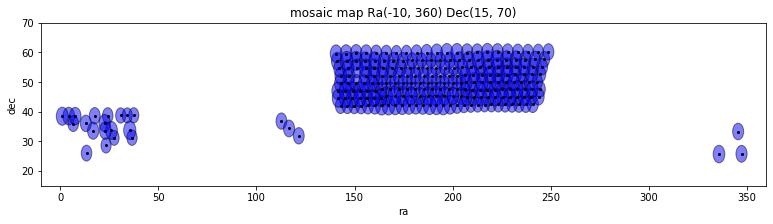

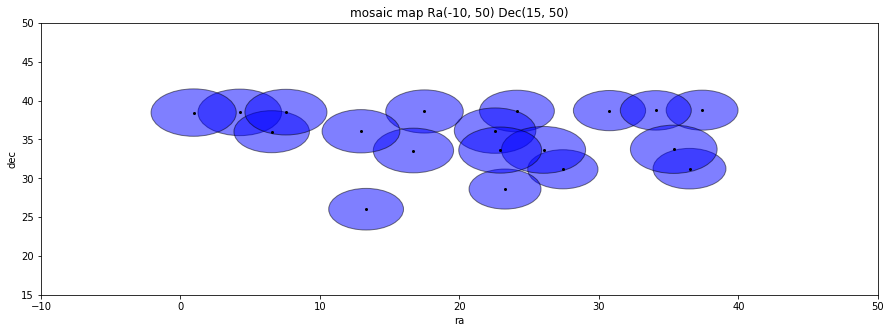

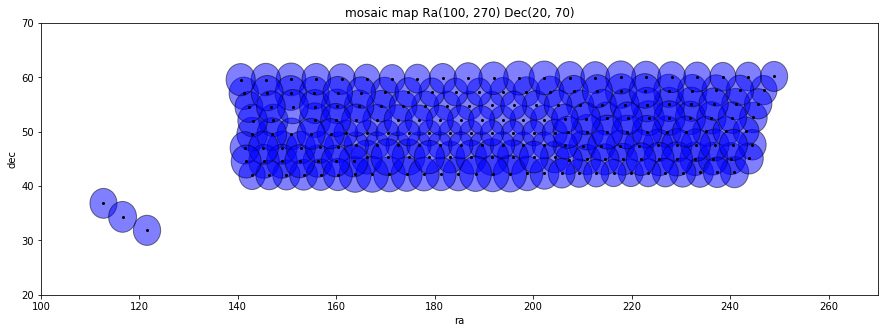

In [13]:
def map_mosaic(info, size=(15, 2), Ra=(-10, 360), Dec=(15, 70)):
    minRa, maxRa = Ra
    minDec, maxDec = Dec
    
    fig, ax = plt.subplots(figsize=size)
    for inf in info:
        ra = inf[1]
        dec = inf[2]
        if (ra >= minRa and ra <= maxRa) and (dec >= minDec and dec <= maxDec):
            ax.add_artist(plt.Circle((ra, dec), inf[0], edgecolor='black', alpha=0.5, facecolor='blue'))
            ax.plot(ra, dec, 'o', markersize=2, color='black')

    plt.xlabel('ra')
    plt.ylabel('dec')
    plt.title('mosaic map Ra({}, {}) Dec({}, {})'.format(minRa, maxRa, minDec, maxDec))
    plt.xlim(minRa, maxRa)
    plt.ylim(minDec, maxDec)


map_mosaic(info, (13, 3))
map_mosaic(info, (15, 5), (-10, 50), (15, 50))
map_mosaic(info, (15, 5), (100, 270), (20, 70))

# Find overlapping mosaics

In [14]:
overlap_dict = {k.split('/')[-1].split('_')[0]: [] for k in fits_files}

for i, f1 in enumerate(fits_files):
    f1 = f1.split('/')[-1].split('_')[0]
    for j, f2 in enumerate(fits_files):
        if j > i:
            f2 = f2.split('/')[-1].split('_')[0]
            offset = np.array((info[i][1] - info[j][1], info[i][2] - info[j][2]))
            distance = np.sqrt(np.sum(np.power(offset, 2)))
            radius = info[i][0] + info[j][0]
            if distance <= radius:
                overlap_dict[f1].append(f2)
                overlap_dict[f2].append(f1)
    if i == 5:
        break

In [15]:
for k, v in overlap_dict.items():
    print(k, len(v))

P037+39 2
P160+55 11
P142+50 8
P40Hetdex19 8
P240+45 8
P227+50 10
P223+52 1
P141+57 0
P37Hetdex15 0
P193+57 0
P024+39 0
P232+55 0
P246+58 0
P147+52 1
P6 0
P182+55 0
P214+52 0
P217+47 0
P227+55 1
P232+45 0
P33Hetdex08 0
P217+57 0
P35Hetdex10 0
P166+60 0
P240+43 1
P222+60 0
P170+42 0
P027+31 0
P225+47 1
P233+43 0
P236+53 0
P210+45 0
P150+60 0
P036+31 0
P187+55 0
P155+57 1
P184+42 0
P26Hetdex03 0
P207+60 0
P34Hetdex06 0
P022+36 0
P236+45 1
P244+53 0
P211+50 0
P231+53 1
P169+57 0
P149+42 0
P32Hetdex08 0
P20Hetdex17 0
P153+42 0
P5Hetdex 0
P22Hetdex04 0
P198+57 0
P5Hetdex41 0
P112+37 0
P24Hetdex20 0
P149+47 0
P227+58 0
P8Hetdex 0
P150+50 0
P27Hetdex09 0
P178+55 0
P181+42 0
P179+57 0
P155+52 1
P163+42 0
P227+53 1
P241+55 0
P210+47 0
P198+42 0
P213+47 0
P145+60 0
P026+34 0
P235+50 0
P245+55 0
P232+58 0
P156+45 0
P203+57 0
P150+57 0
P169+55 0
P209+42 0
P11Hetdex12 0
P335+26 0
P228+60 0
P181+60 0
P221+47 0
P207+45 1
P236+48 1
P146+50 1
P237+58 0
P145+45 1
P200+55 0
P030+39 0
P219+42 0
P191+55 0


In [16]:
overlaps = sc.parallelize(list(overlap_dict.items()), 32).flatMap(lambda x : map(lambda y: tuple(sorted((x[0], y))), x[1])).distinct()
overlaps.collect()

[('P227+50', 'P229+45'),
 ('P142+50', 'P146+50'),
 ('P160+55', 'P160+57'),
 ('P160+55', 'P165+57'),
 ('P223+52', 'P227+50'),
 ('P155+55', 'P160+55'),
 ('P40Hetdex19', 'P42Hetdex07'),
 ('P227+50', 'P227+55'),
 ('P225+47', 'P227+50'),
 ('P160+55', 'P2Hetdex01'),
 ('P159+52', 'P160+55'),
 ('P158+50', 'P160+55'),
 ('P142+50', 'P142+55'),
 ('P160+55', 'P161+60'),
 ('P1Hetdex15', 'P40Hetdex19'),
 ('P39Hetdex19', 'P40Hetdex19'),
 ('P206+50', 'P40Hetdex19'),
 ('P141+45', 'P142+50'),
 ('P160+55', 'P4Hetdex16'),
 ('P142+50', 'P143+52'),
 ('P207+45', 'P40Hetdex19'),
 ('P205+42', 'P40Hetdex19'),
 ('P034+39', 'P037+39'),
 ('P227+50', 'P231+53'),
 ('P202+42', 'P40Hetdex19'),
 ('P236+48', 'P240+45'),
 ('P155+52', 'P160+55'),
 ('P142+50', 'P147+52'),
 ('P227+50', 'P231+50'),
 ('P155+57', 'P160+55'),
 ('P142+50', 'P145+47'),
 ('P240+45', 'P240+48'),
 ('P227+50', 'P229+48'),
 ('P237+43', 'P240+45'),
 ('P239+50', 'P240+45'),
 ('P240+45', 'P244+48'),
 ('P36Hetdex10', 'P40Hetdex19'),
 ('P160+55', 'P164+55'

# Prepare catalogue

In [17]:
header = ["label", "total_pixels", "x_pixels", "y_pixels",
          "integrated_intensity", "brightest_pixel", "brightest_pixel_x", "brightest_pixel_y",
          "brightest_pixel_RA", "brightest_pixel_DEC", "center_of_mass_x", "center_of_mass_y",
          "center_of_mass_RA", "center_of_mass_DEC", "center_of_gaus_fit_x", "center_of_gaus_fit_y",
          "center_of_gaus_fit_RA", "center_of_gaus_fit_DEC", "fit_x_axis", "fit_y_axis", "fit_theta",
          "deconv_x", "deconv_y", "integrated_intensity_fit", "ratio_residual"
         ]
catalogue = pd.read_csv(writeable + "catalogue_v5.csv", sep=",", names=header)

# Filter nans
rows = len(catalogue)
nan_rows = catalogue[catalogue.isnull().any(axis=1)]
ratio_nan = len(nan_rows) / rows
print('{0:.2f}% nan rows'.format(ratio_nan * 100))

# Show new catalogue
catalogue = catalogue[~catalogue.index.isin(nan_rows.index)].reindex()
catalogue['overlap'] = 0

# Add mosaic
catalogue['mosaic'], catalogue['object'] = catalogue['label'].str.split('_', 1).str
catalogue['object'] = catalogue['object'].astype(int)
catalogue.head()

0.15% nan rows


label  total_pixels  x_pixels  y_pixels  integrated_intensity  \
0  P191+55_0            43         7         7              0.961113   
1  P191+55_1            20         7         5              0.326739   
2  P191+55_2            45         8         7              0.745168   
3  P191+55_3            43        10         7              0.702810   
4  P191+55_4            74        14         9              1.104583   

   brightest_pixel  brightest_pixel_x  brightest_pixel_y  brightest_pixel_RA  \
0         0.001262               4195                 13          191.526076   
1         0.000757               4605                 27          191.241494   
2         0.000793               3745                 32          191.838427   
3         0.000809               3775                 33          191.817606   
4         0.000829               4346                 35          191.421253   

   brightest_pixel_DEC  ...  fit_x_axis  fit_y_axis  fit_theta  deconv_x  \
0            53.102602  ...    1.719762    1.896624  -0.532125  0.632697   
1            53.108014  ...    1.519698    1.080085   0.057949  0.000000   
2            53.110190  ...    2.200380    1.810050  -0.030505  3.293620   
3            53.110655  ...    1.720535    2.116901   0.055498  0.644249   
4            53.111697  ...    3.113873    2.061817  -0.772092  6.145499   

   deconv_y  integrated_intensity_fit  ratio_residual  overlap   mosaic  \
0  1.986707                  0.971715        0.020838        0  P191+55   
1  0.000000                  0.330021        0.193748        0  P191+55   
2  1.472263                  0.761026        0.051991        0  P191+55   
3  2.974800                  0.705155        0.082425        0  P191+55   
4  2.751915                  1.080358        0.161090        0  P191+55   

   object  
0       0  
1       1  
2       2  
3       3  
4       4  

[5 rows x 28 columns]

# Finding overlapping sources

In [18]:
key = overlaps.take(237)[-1][0]
value = overlaps.take(237)[-1][1]
print(key, value)
catalogue[(catalogue["mosaic"] == key) | (catalogue["mosaic"] == value)].sort_values(by=["brightest_pixel_RA", "brightest_pixel_DEC"]).head()

P240+45 P243+45


label  total_pixels  x_pixels  y_pixels  integrated_intensity  \
339065  P240+45_3428            26         5         7              0.479621   
338999  P240+45_3362            26         7         6              0.320425   
339093  P240+45_3456            20         6         5              0.335010   
339746  P240+45_4109            33         7         7              0.673062   
339666  P240+45_4029            35         7         6              0.530112   

        brightest_pixel  brightest_pixel_x  brightest_pixel_y  \
339065         0.000802               9390               4611   
338999         0.000451               9384               4547   
339093         0.000672               9371               4645   
339746         0.000980               9350               5231   
339666         0.000535               9352               5161   

        brightest_pixel_RA  brightest_pixel_DEC  ...  fit_x_axis  fit_y_axis  \
339065          237.434719            44.992753  ...    1.866446    1.664295   
338999          237.439539            44.966187  ...    2.215200    1.527580   
339093          237.445232            45.007182  ...    1.478507    1.348895   
339746          237.445832            45.251505  ...    1.567939    1.765279   
339666          237.446063            45.222327  ...    2.623016    1.918281   

        fit_theta  deconv_x  deconv_y  integrated_intensity_fit  \
339065  -0.486676  1.821343  0.000000                  0.490611   
338999  -0.702875  3.348253  0.000000                  0.323858   
339093  -0.779600  0.000000  0.000000                  0.347253   
339746  -0.735174  0.000000  1.131343                  0.694882   
339666   0.499196  4.706591  2.098847                  0.537101   

        ratio_residual  overlap   mosaic  object  
339065        0.069755        0  P240+45    3428  
338999        0.220260        0  P240+45    3362  
339093        0.100051        0  P240+45    3456  
339746        0.078266        0  P240+45    4109  
339666        0.077425        0  P240+45    4029  

[5 rows x 28 columns]

In [19]:
mosaic_dict = {k: i for i, k in enumerate(overlap_dict.keys()) }
mosaic_dict_rev = {i: k for i, k in enumerate(overlap_dict.keys()) }
mosaic_dict

{'P037+39': 0,
 'P160+55': 1,
 'P142+50': 2,
 'P40Hetdex19': 3,
 'P240+45': 4,
 'P227+50': 5,
 'P223+52': 6,
 'P141+57': 7,
 'P37Hetdex15': 8,
 'P193+57': 9,
 'P024+39': 10,
 'P232+55': 11,
 'P246+58': 12,
 'P147+52': 13,
 'P6': 14,
 'P182+55': 15,
 'P214+52': 16,
 'P217+47': 17,
 'P227+55': 18,
 'P232+45': 19,
 'P33Hetdex08': 20,
 'P217+57': 21,
 'P35Hetdex10': 22,
 'P166+60': 23,
 'P240+43': 24,
 'P222+60': 25,
 'P170+42': 26,
 'P027+31': 27,
 'P225+47': 28,
 'P233+43': 29,
 'P236+53': 30,
 'P210+45': 31,
 'P150+60': 32,
 'P036+31': 33,
 'P187+55': 34,
 'P155+57': 35,
 'P184+42': 36,
 'P26Hetdex03': 37,
 'P207+60': 38,
 'P34Hetdex06': 39,
 'P022+36': 40,
 'P236+45': 41,
 'P244+53': 42,
 'P211+50': 43,
 'P231+53': 44,
 'P169+57': 45,
 'P149+42': 46,
 'P32Hetdex08': 47,
 'P20Hetdex17': 48,
 'P153+42': 49,
 'P5Hetdex': 50,
 'P22Hetdex04': 51,
 'P198+57': 52,
 'P5Hetdex41': 53,
 'P112+37': 54,
 'P24Hetdex20': 55,
 'P149+47': 56,
 'P227+58': 57,
 'P8Hetdex': 58,
 'P150+50': 59,
 'P27Hetde

In [20]:
catalogue["mosaic_id"] = catalogue["mosaic"].apply(lambda x: mosaic_dict[x])
catalogue.loc[:, ["mosaic", "mosaic_id"]]

mosaic  mosaic_id
0        P191+55         94
1        P191+55         94
2        P191+55         94
3        P191+55         94
4        P191+55         94
...          ...        ...
2291390  P198+57         52
2291391  P198+57         52
2291392  P198+57         52
2291393  P198+57         52
2291394  P198+57         52

[2287879 rows x 2 columns]

In [21]:
def detectOverlap(data, labels): 
    # Define new df
    obj_rows = []
    
    # Define distance between brightest pixel
    eps = 0.0016
    i = 0
    # print('Finding overlaps between:', k, 'and', v)
    
    while i < len(data)-1:
        # Same mosaic
        # print(labels[i][0], labels[i+1][0])
        if labels[i][0] == labels[i+1][0]:
            # print('skip')
            i += 1
            continue
        
        if ((data[i + 1][0] >= data[i][0]-eps and data[i + 1][0] <= data[i][0]+eps) and 
            (data[i + 1][1] >= data[i][1]-eps and data[i + 1][1] <= data[i][1]+eps)):      
            
            # Add to new rows
            obj_rows.append(np.array(sorted([labels[i], labels[i+1]], key=lambda x: x[0])).astype(int))
            # obj_rows.append(np.array(sorted([labels[i], labels[i+1]])).astype(int))
            
            # Only 2 sources can overlap
            i += 2
        else:
            i += 1
    
    return np.array(obj_rows)

In [22]:
np.array(sorted([[2, 5], [2, 4]]))

array([[2, 4],
       [2, 5]])

In [23]:
# k = overlaps.take(237)[-1][0]
# v = overlaps.take(237)[-1][1]

select = lambda s, k, v: np.array_split(np.array(
    s[(s["mosaic"] == k) | (s["mosaic"] == v)]
    .sort_values(by=["brightest_pixel_RA", "brightest_pixel_DEC"])
    .loc[:, ["brightest_pixel_RA", "brightest_pixel_DEC", "mosaic_id", "object"]]
), 2, axis=1)


# select(catalogue, overlaps.take(237)[-1][0], overlaps.take(237)[-1][1])


In [24]:
overlap_rows = overlaps.flatMap(lambda o: detectOverlap(np.around(select(catalogue, o[0], o[1])[0], 5), # o[0] + "_" + o[1],
                                          select(catalogue, o[0], o[1])[1].astype(int),
                                                       )
                               )

In [25]:
# test_overlap = overlap_rows.collect()
# test_overlap

# Group overlapping sources

In [26]:
grouped_overlaps = overlap_rows.map(lambda x: (tuple(x[0]), x[1])).groupByKey().mapValues(list)

In [27]:
test_grouped_overlaps = grouped_overlaps.collect()
test_grouped_overlaps

[((2, 9112), [array([   88, 11253]), array([ 136, 1422])]),
 ((2, 2328), [array([  88, 2784]), array([  169, 11265])]),
 ((2, 6616), [array([  88, 8081])]),
 ((2, 6296), [array([  88, 7689])]),
 ((2, 3672), [array([  88, 4425])]),
 ((2, 4248), [array([  88, 5112])]),
 ((2, 8376), [array([   88, 10287])]),
 ((2, 5816), [array([  88, 6987])]),
 ((2, 8728), [array([   88, 10799])]),
 ((2, 1464), [array([  88, 1772])]),
 ((2, 4376), [array([  88, 5324])]),
 ((2, 8248), [array([   88, 10211])]),
 ((2, 5432), [array([  88, 6480])]),
 ((2, 2744), [array([  88, 3280]), array([  169, 11583])]),
 ((2, 7896), [array([  88, 9616])]),
 ((2, 4056), [array([  88, 4909])]),
 ((2, 6040), [array([  88, 7384])]),
 ((2, 3000), [array([  88, 3483])]),
 ((2, 1880), [array([  88, 2238])]),
 ((2, 2904), [array([  88, 3535]), array([  169, 11678])]),
 ((2, 5560), [array([  88, 6841])]),
 ((2, 7544), [array([  88, 9281])]),
 ((2, 8184), [array([   88, 10141])]),
 ((2, 2040), [array([  88, 2485])]),
 ((2, 5240),

In [35]:
test = []
# print(len(test_grouped_overlaps))
for line in test_grouped_overlaps:
    # print(line)
    # print(labelOverlap(line, [lookup(catalogue, i[0], i[1]) for i in line[1]] ) )
    test.append(labelOverlap(line, [lookup(catalogue, i[0], i[1]) for i in line[1]] ))

In [43]:
for i in test:
    for j in i:
        catalogue[(catalogue["mosaic_id"] == j[0]) & (catalogue["object"] == j[1])]["overlap"] = j[2]

KeyboardInterrupt: 

In [ ]:
catalogue.head()

# Label overlapping sources

In [37]:
def flatten(L):
    for item in L:
        try:
            yield from flatten(item)
        except TypeError:
            yield item
            
            
def labelOverlap(combs, pixels):
    combs = tuple(flatten(combs))
    pixels = tuple(flatten(pixels))
    it = iter(combs)
    combs = tuple(zip(*[it]*2))
    overlap_arr = np.ones((len(combs), 3), dtype=int)
    biggest = -1
    idx = 0
    for i, (c, pix) in enumerate(zip(combs, pixels)):
        overlap_arr[i, :2] = c
        if pix > biggest:
            biggest = pix
            idx = i
    overlap_arr[idx, 2] += 1
    return overlap_arr

In [38]:
[i for i in ([tuple((57, 7448)), tuple((57, 7448))]) ]

[(57, 7448), (57, 7448)]

In [39]:
lookup = lambda d, mos, obj: int(d[(d["mosaic_id"] == mos) & (d["object"] == obj)]["total_pixels"].values)

k = (184, 9062)
v = [tuple((57, 7448)), tuple((57, 7448))]
labelOverlap( (k, v),
             (lookup(catalogue, k[0], k[1]), [lookup(catalogue, i[0], i[1]) for i in v])
            )

for k, v in test_grouped_overlaps:
    print(k,v)
    break

TypeError: only size-1 arrays can be converted to Python scalars

In [40]:
labeled_overlaps = grouped_overlaps.map(lambda lo: labelOverlap((lo[0], lo[1]), 
                                                                (lookup(catalogue, lo[0][0], lo[0][1]),
                                                                 [lookup(catalogue, v[0], v[1]) for v in lo[1]],
                                                                )
                                                               )
                                           )
labeled_overlaps.coalesce(1).saveAsTextFile("newfile")

Py4JJavaError: An error occurred while calling o11.broadcast.
: java.lang.OutOfMemoryError: Java heap space
	at java.nio.HeapByteBuffer.<init>(HeapByteBuffer.java:57)
	at java.nio.ByteBuffer.allocate(ByteBuffer.java:335)
	at org.apache.spark.broadcast.TorrentBroadcast$$anonfun$3.apply(TorrentBroadcast.scala:286)
	at org.apache.spark.broadcast.TorrentBroadcast$$anonfun$3.apply(TorrentBroadcast.scala:286)
	at org.apache.spark.util.io.ChunkedByteBufferOutputStream.allocateNewChunkIfNeeded(ChunkedByteBufferOutputStream.scala:87)
	at org.apache.spark.util.io.ChunkedByteBufferOutputStream.write(ChunkedByteBufferOutputStream.scala:75)
	at net.jpountz.lz4.LZ4BlockOutputStream.flushBufferedData(LZ4BlockOutputStream.java:220)
	at net.jpountz.lz4.LZ4BlockOutputStream.write(LZ4BlockOutputStream.java:173)
	at java.io.ObjectOutputStream$BlockDataOutputStream.write(ObjectOutputStream.java:1853)
	at java.io.ObjectOutputStream.write(ObjectOutputStream.java:709)
	at org.apache.spark.util.Utils$$anonfun$copyStream$1.apply$mcJ$sp(Utils.scala:363)
	at org.apache.spark.util.Utils$$anonfun$copyStream$1.apply(Utils.scala:348)
	at org.apache.spark.util.Utils$$anonfun$copyStream$1.apply(Utils.scala:348)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.util.Utils$.copyStream(Utils.scala:369)
	at org.apache.spark.api.python.PythonBroadcast$$anonfun$writeObject$1.apply$mcJ$sp(PythonRDD.scala:696)
	at org.apache.spark.api.python.PythonBroadcast$$anonfun$writeObject$1.apply(PythonRDD.scala:693)
	at org.apache.spark.api.python.PythonBroadcast$$anonfun$writeObject$1.apply(PythonRDD.scala:693)
	at org.apache.spark.util.Utils$.tryOrIOException(Utils.scala:1326)
	at org.apache.spark.api.python.PythonBroadcast.writeObject(PythonRDD.scala:693)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1028)
	at java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1496)
	at java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1432)
	at java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1178)
	at java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:348)
	at org.apache.spark.serializer.JavaSerializationStream.writeObject(JavaSerializer.scala:43)
	at org.apache.spark.broadcast.TorrentBroadcast$$anonfun$blockifyObject$2.apply(TorrentBroadcast.scala:291)
	at org.apache.spark.broadcast.TorrentBroadcast$$anonfun$blockifyObject$2.apply(TorrentBroadcast.scala:291)


# Apply to catalogue

In [ ]:
def filterCatalogue(df, o_mosaics):
    for mat in o_mosaics:
        mos1, obj1 = mat[0]
        mos2, obj2 = mat[1]
        line1 = df[(df["mosaic_id"] == mos1) & (df["object"] == obj1)]
        line2 = df[(df["mosaic_id"] == mos2) & (df["object"] == obj2)]
        # print(int(line2["total_pixels"]))
        if int(line1["total_pixels"]) >= int(line2["total_pixels"]):
            # If already overlaps and is smaller do not change it
            if int(line1["overlap"]) != 1:
                line1["overlap"] = 2
            line2["overlap"] = 1
        else:
            # If already overlaps and is smaller do not change it
            if int(line2["overlap"]) != 1:
                line2["overlap"] = 2
            line1["overlap"] = 1

    return df

In [ ]:
# lookup = lambda d, l: d[d["label"] == l]
print(len(test_overlap))
filt_catalogue = filterCatalogue(catalogue, test_overlap)
filt_catalogue.head()

# Verify

In [ ]:
i = test_overlap[0][1][0][0]
catalogue[catalogue["label"] == mosaic_dict_rev[i[0]] + '_' + str(i[1])]

In [ ]:
i = test_overlap[0][1][0][1]
catalogue[catalogue["label"] == mosaic_dict_rev[i[0]] + '_' + str(i[1])]

In [ ]:
catalogue[(catalogue["mosaic_id"] == 20)] 